In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

mnist, labels = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
mnist = mnist.astype('float32') / 255.0
labels = labels.astype(int)

print(f"total number of samples:{labels.size}")

total number of samples:70000


In [2]:
x_train = mnist[:60000,:]
y_train = labels[:60000]

x_test = mnist[60000:,:]
y_test = labels[60000:]

In [3]:
# Define the two classes you want to keep
classes_to_keep = [3, 7]

# Create a boolean mask for the training data
train_keep_mask = np.isin(y_train, classes_to_keep)

# Apply the mask to your training data and labels
x_train_2_classes = x_train[train_keep_mask]
y_train_2_classes = y_train[train_keep_mask]

# Do the same for the test data
test_keep_mask = np.isin(y_test, classes_to_keep)
x_test_2_classes = x_test[test_keep_mask]
y_test_2_classes = y_test[test_keep_mask]

# Verification
print("Original training data shape:", x_train.shape)
print("Original training labels shape:", y_train.shape)
print("Original test data shape:", x_test.shape)
print("Original test labels shape:", y_test.shape)
print("-" * 30)
print("New training data shape (2 classes):", x_train_2_classes.shape)
print("New training labels shape (2 classes):", y_train_2_classes.shape)
print("New test data shape (2 classes):", x_test_2_classes.shape)
print("New test labels shape (2 classes):", y_test_2_classes.shape)
print("\nUnique labels in the new training set:", np.unique(y_train_2_classes))
print("Unique labels in the new test set:", np.unique(y_test_2_classes))

Original training data shape: (60000, 784)
Original training labels shape: (60000,)
Original test data shape: (10000, 784)
Original test labels shape: (10000,)
------------------------------
New training data shape (2 classes): (12396, 784)
New training labels shape (2 classes): (12396,)
New test data shape (2 classes): (2038, 784)
New test labels shape (2 classes): (2038,)

Unique labels in the new training set: [3 7]
Unique labels in the new test set: [3 7]


In [4]:
# map class 3 -> 0 and class 7 -> 1
# get the original class names from our list
class_a = classes_to_keep[0] # 3
class_b = classes_to_keep[1] # 7

# Use np.where to re-label
y_train_binary = np.where(y_train_2_classes == class_a, 0, 1)
y_test_binary = np.where(y_test_2_classes == class_a, 0, 1)

print("\n--- After Re-labeling ---")
print("New binary training labels:", y_train_binary)
print("Unique binary training labels:", np.unique(y_train_binary))
print("New binary test labels:", y_test_binary)
print("Unique binary test labels:", np.unique(y_test_binary))


--- After Re-labeling ---
New binary training labels: [0 0 0 ... 0 1 0]
Unique binary training labels: [0 1]
New binary test labels: [1 1 0 ... 0 1 0]
Unique binary test labels: [0 1]


In [5]:
x_train_2_classes_final = np.hstack((x_train_2_classes, np.ones((x_train_2_classes.shape[0], 1))))
x_test_2_classes_final = np.hstack((x_test_2_classes, np.ones((x_test_2_classes.shape[0], 1))))

In [6]:
# Sigmoid activation function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Compute logistic regression loss (binary cross-entropy)
def compute_loss(w, X, y):
    z = X @ w
    predictions = sigmoid(z)
    loss = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
    return loss

# Compute gradient of the loss weights
def compute_gradient(w, X, y):
    z = X @ w
    predictions = sigmoid(z)
    errors = predictions - y
    gradient = X.T @ errors / len(y)
    return gradient

# Evaluate validation accuracy
def validation_accuracy(w, X_val, y_val):
    probabilities = sigmoid(X_val @ w)
    predictions = (probabilities > 0.5).astype(int)
    accuracy = np.mean(predictions == y_val)
    return accuracy

In [7]:
# Gradient descent for logistic regression with early stopping based on validation loss
def gradient_descent_logistic(X_train, y_train, X_val, y_val, learning_rate=0.1, n_steps=1000,
                            patience=10, min_delta=1e-4):
    """
    Perform gradient descent for logistic regression with early stopping based on validation loss.

    Parameters:
    - X_train, y_train: Training data
    - X_val, y_val: Validation data
    - learning_rate: Learning rate for gradient descent
    - n_steps: Maximum number of steps
    - patience: Number of steps to wait without improvement in validation loss before stopping
    - min_delta: Minimum change in validation loss to be considered an improvement

    Returns:
    - w: Final weights
    - loss_history: Training loss history
    - val_loss_history: Validation loss history
    - val_accuracy_history: Validation accuracy history
    """
    # Initialize weights
    w = np.zeros(X_train.shape[1])
    # Track loss, accuracy, and weights
    loss_history = [compute_loss(w, X_train, y_train)]
    val_loss_history = [compute_loss(w, X_val, y_val)]
    train_accuracy_history = [validation_accuracy(w, X_train, y_train)]
    val_accuracy_history = [validation_accuracy(w, X_val, y_val)]

    # Variables for early stopping
    best_val_loss = val_loss_history[0]
    best_weights = w.copy()
    wait = 0  # Counter for patience

    # Main training loop
    for step in range(1, n_steps + 1):
        grad = compute_gradient(w, X_train, y_train)
        w -= learning_rate * grad  # Update weights

        # Compute training and validation losses
        train_loss = compute_loss(w, X_train, y_train)
        val_loss = compute_loss(w, X_val, y_val)
        loss_history.append(train_loss)
        val_loss_history.append(val_loss)

        # Compute train and validation accuracy
        train_acc = validation_accuracy(w, X_train, y_train)
        train_accuracy_history.append(train_acc)
        val_acc = validation_accuracy(w, X_val, y_val)
        val_accuracy_history.append(val_acc)

        # Early stopping based on validation loss
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_weights = w.copy()
            wait = 0  # Reset wait counter
        else:
            wait += 1
            if wait >= patience:
                print(f'Early stopping at step {step} due to no improvement in validation loss')
                w = best_weights  # Restore best weights
                break

        # Log progress every 100 steps
        if step % 100 == 0:
            print(f'Step {step}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Accuracy = {val_acc:.4f}')

    return w, loss_history, val_loss_history, train_accuracy_history, val_accuracy_history

In [8]:
# Set learning rate and number of steps
learning_rate = 0.1
n_steps = 2000

# Train logistic regression model with gradient descent
w_opt, loss_history, val_loss_history, train_accuracy_history, val_accuracy_history = gradient_descent_logistic(
    x_train_2_classes_final[:10000,:], y_train_binary[:10000], x_train_2_classes_final[10000:,:], y_train_binary[10000:],
    learning_rate=learning_rate,
    n_steps=n_steps,
)

Step 100: Train Loss = 0.0892, Val Loss = 0.0759, Val Accuracy = 0.9816
Step 200: Train Loss = 0.0734, Val Loss = 0.0611, Val Accuracy = 0.9837
Step 300: Train Loss = 0.0661, Val Loss = 0.0545, Val Accuracy = 0.9846
Step 400: Train Loss = 0.0615, Val Loss = 0.0504, Val Accuracy = 0.9850
Step 500: Train Loss = 0.0583, Val Loss = 0.0476, Val Accuracy = 0.9858
Step 600: Train Loss = 0.0559, Val Loss = 0.0454, Val Accuracy = 0.9866
Step 700: Train Loss = 0.0539, Val Loss = 0.0438, Val Accuracy = 0.9871
Step 800: Train Loss = 0.0523, Val Loss = 0.0424, Val Accuracy = 0.9887
Step 900: Train Loss = 0.0509, Val Loss = 0.0413, Val Accuracy = 0.9887
Early stopping at step 934 due to no improvement in validation loss


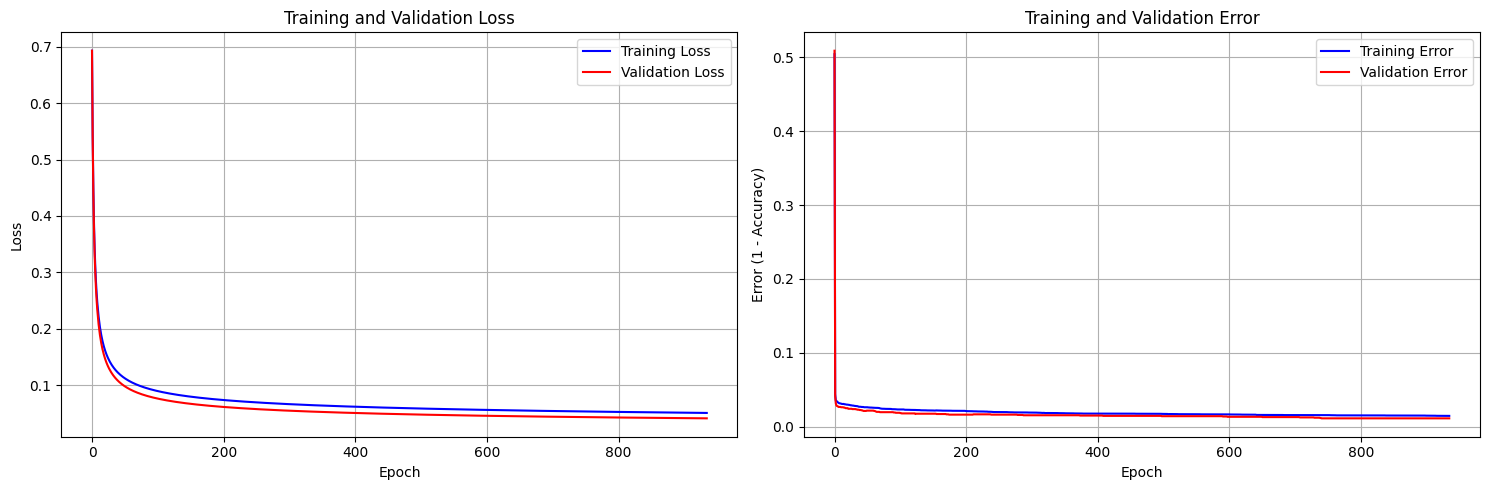

In [9]:
def plot_training_history(loss_history, val_loss_history, train_accuracy_history, val_accuracy_history, save_path=None):
    """
    Plot training and validation loss and error curves.

    Parameters:
    - loss_history: Training loss history
    - val_loss_history: Validation loss history
    - train_accuracy_history: Training accuracy history
    - val_accuracy_history: Validation accuracy history
    - save_path: Path to save the plot (optional)
    """
    # Convert accuracy to error (1 - accuracy)
    train_error_history = [1 - acc for acc in train_accuracy_history]
    val_error_history = [1 - acc for acc in val_accuracy_history]

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss curves
    ax1.plot(loss_history, label='Training Loss', color='blue')
    ax1.plot(val_loss_history, label='Validation Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot error curves
    ax2.plot(train_error_history, label='Training Error', color='blue')
    ax2.plot(val_error_history, label='Validation Error', color='red')
    ax2.set_title('Training and Validation Error')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Error (1 - Accuracy)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    else:
        plt.show()

plot_training_history(loss_history, val_loss_history, train_accuracy_history, val_accuracy_history)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def accuracy(y_true, y_pred):
    """
    Calculate accuracy for binary classification.

    Parameters:
    - y_true: True labels
    - y_pred: Predicted labels

    Returns:
    - accuracy: Accuracy score
    """
    cm = calculate_confusion_matrix(y_true, y_pred)
    tp = cm[1, 1]
    tn = cm[0, 0]

    # Total number of predictions is the sum of all values in the matrix
    total_predictions = cm.sum()

    # Handle division by zero
    if total_predictions == 0:
        return 0

    return (tp + tn) / total_predictions

def calculate_confusion_matrix(y_true, y_pred):
    """
    Calculate the confusion matrix for binary classification.

    Parameters:
    - y_true: True labels
    - y_pred: Predicted labels

    Returns:
    - confusion_matrix: 2x2 numpy array [[TN, FP], [FN, TP]]
    """
    # Initialize the confusion matrix
    cm = np.zeros((2, 2), dtype=int)

    # Calculate True Positive, True Negative, False Positive, False Negative
    for true, pred in zip(y_true, y_pred):
        if true == 1 and pred == 1:
            cm[1, 1] += 1  # True Positive
        elif true == 0 and pred == 0:
            cm[0, 0] += 1  # True Negative
        elif true == 0 and pred == 1:
            cm[0, 1] += 1  # False Positive
        elif true == 1 and pred == 0:
            cm[1, 0] += 1  # False Negative

    return cm

def precision(y_true, y_pred):
    """
    Calculate precision for binary classification.

    Parameters:
    - y_true: True labels
    - y_pred: Predicted labels

    Returns:
    - precision: Precision score
    """
    cm = calculate_confusion_matrix(y_true, y_pred)
    tp = cm[1, 1]
    fp = cm[0, 1]

    # Handle division by zero
    if tp + fp == 0:
        return 0

    return tp / (tp + fp)

def recall(y_true, y_pred):
    """
    Calculate recall for binary classification.

    Parameters:
    - y_true: True labels
    - y_pred: Predicted labels

    Returns:
    - recall: Recall score
    """
    cm = calculate_confusion_matrix(y_true, y_pred)
    tp = cm[1, 1]
    fn = cm[1, 0]

    # Handle division by zero
    if tp + fn == 0:
        return 0

    return tp / (tp + fn)

def f1_score(y_true, y_pred):
    """
    Calculate F1-score for binary classification.

    Parameters:
    - y_true: True labels
    - y_pred: Predicted labels

    Returns:
    - f1: F1-score
    """
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)

    # Handle division by zero
    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)


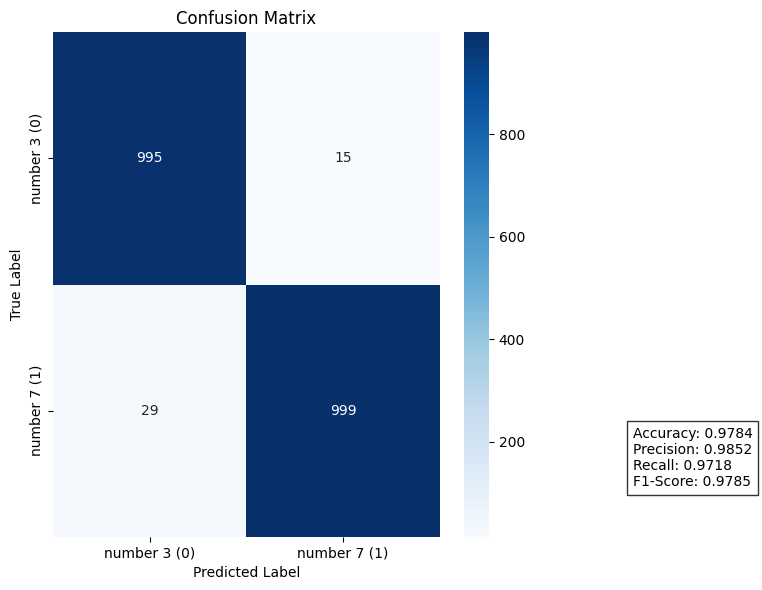

In [11]:
def plot_confusion_matrix(y_true, y_pred, class_names=None, figsize=(8, 6)):
    """
    Plot the confusion matrix for binary classification.

    Parameters:
    - y_true: True labels
    - y_pred: Predicted labels
    - class_names: List of class names (optional)
    - figsize: Figure size (width, height)

    Returns:
    - fig: matplotlib figure object
    """
    # Calculate confusion matrix
    cm = calculate_confusion_matrix(y_true, y_pred)

    # Set default class names if not provided
    if class_names is None:
        class_names = ['number 3 (0)', 'number 7 (1)']

    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)

    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax)

    # Add labels and title
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix')

    # Calculate and display metrics
    acc = accuracy(y_true, y_pred)
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    metrics_text = f'Accuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall: {rec:.4f}\nF1-Score: {f1:.4f}'
    ax.text(1.5, 0.1, metrics_text, transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    return fig

# Compute model outputs and predictions on test set
z_val = x_test_2_classes_final @ w_opt
probabilities_val = sigmoid(z_val)
predictions_val = (probabilities_val > 0.5).astype(int)

y_true = y_test_binary
y_pred = predictions_val

# Plot confusion matrix
fig = plot_confusion_matrix(y_true, y_pred)
plt.show()